# several ML regression methods test and hyperparameters tuning procedure

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import missingno as msno
import random

%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

True


365

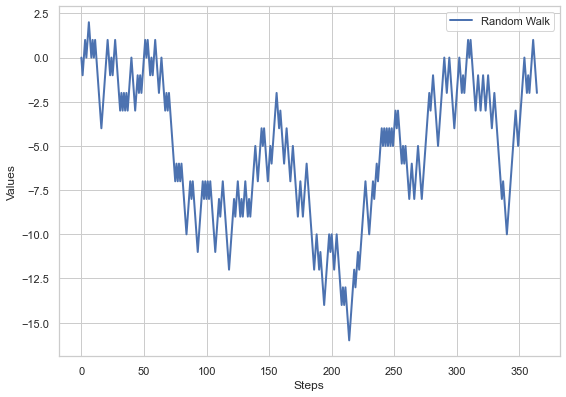

In [2]:
# 生成随机漫步序列

position = 0
walk = [position]
steps = 364
for i in range(steps):
    if random.randint(0,1) == 1:
        step = 1
    else: step = -1
    position = position + step
    walk.append(position)
x = list(range(steps+1))
plt.figure(figsize=(8,6))
plt.plot(x,walk[:steps+1],linewidth=2,label='Random Walk')
plt.xlabel('Steps')
plt.ylabel('Values')
plt.legend()
print(len(walk) == len(x))
len(walk)

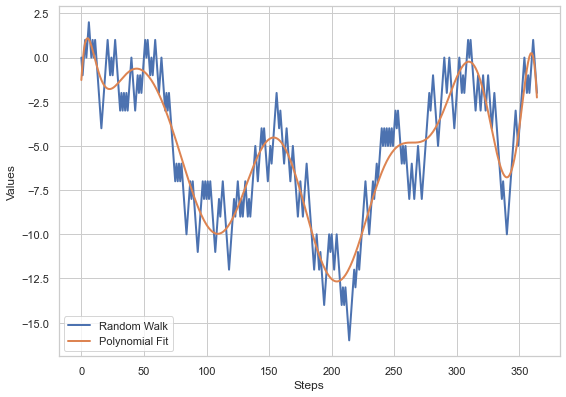

In [3]:
# 使用高次多项式拟合随机漫步序列

coe_poly = np.polyfit(x,walk,15) # polyfit方法拟合x与walk，生成多项式系数。
func_poly = np.poly1d(coe_poly)  # poly1d方法使用系数生成多项式函数。
value_poly = func_poly(x)
plt.figure(figsize=(8,6))
plt.plot(x,walk,linewidth=2,label='Random Walk')
plt.plot(x,value_poly,linewidth=2,label='Polynomial Fit')
plt.xlabel('Steps')
plt.ylabel('Values')
plt.legend()

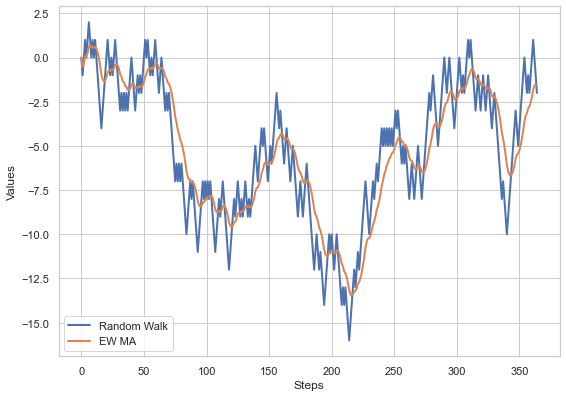

In [4]:
# 使用指数加权移动平均拟合随机漫步序列

walk = pd.Series(walk)
ewma = walk.ewm(span=15).mean()
plt.figure(figsize=(8,6))
plt.plot(x,walk,linewidth=2,label='Random Walk')
plt.plot(x,ewma,linewidth=2,label='EW MA')
plt.xlabel('Steps')
plt.ylabel('Values')
plt.legend()

In [57]:
# 读取训练集和验证集
train = pd.read_csv('train.csv')
train_df = train.copy()
print(train_df.info(), '\n')
print('数据集中单品个数:', '\n', len(train_df.groupby(by=['code'])['code']), '\n')
print('各单品时序的长度:', '\n', train_df.groupby(by=['code'])['code'].count(), '\n')
train_df.describe()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6006 entries, 0 to 6005
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   code        6006 non-null   int64  
 1   class       6006 non-null   int64  
 2   busdate     6006 non-null   object 
 3   weekday     6006 non-null   int64  
 4   week        6006 non-null   int64  
 5   festival    6006 non-null   int64  
 6   fix_amount  6006 non-null   float64
 7   price       6006 non-null   float64
 8   sum_price   6006 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 422.4+ KB
None 

数据集中单品个数: 
 6 

各单品的时序长度: 
 code
6901285991219    1001
6907992100272    1001
6907992500133    1001
6907992508191    1001
6921168509256    1001
6923644223458    1001
Name: code, dtype: int64 



,code,class,busdate,weekday,week,festival,fix_amount,price,sum_price
0,6921168509256,10,2015-12-20,6,51,0,2.0,1.8,3.6
1,6921168509256,10,2015-12-21,0,52,0,3.0,1.8,5.4
2,6921168509256,10,2015-12-22,1,52,0,2.0,1.8,3.6
3,6921168509256,10,2015-12-23,2,52,0,2.0,1.8,3.6
4,6921168509256,10,2015-12-24,3,52,0,1.0,1.8,1.8


In [6]:
# 读取测试集
test = pd.read_csv('test.csv')
test_df = test.copy()
print(test_df.info())
test_df.describe()
test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086 entries, 0 to 1085
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   code        1086 non-null   int64  
 1   class       1086 non-null   int64  
 2   busdate     1086 non-null   object 
 3   weekday     1086 non-null   int64  
 4   week        1086 non-null   int64  
 5   festival    1086 non-null   int64  
 6   fix_amount  1086 non-null   float64
 7   price       1086 non-null   float64
 8   sum_price   1086 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 76.5+ KB
None


,code,class,busdate,weekday,week,festival,fix_amount,price,sum_price
0,6921168509256,10,2018-09-16,6,37,7,12.0,1.5,18.0
1,6921168509256,10,2018-09-17,0,38,7,7.0,1.5,10.5
2,6921168509256,10,2018-09-18,1,38,7,5.0,1.5,7.5
3,6921168509256,10,2018-09-19,2,38,7,15.0,1.5,22.5
4,6921168509256,10,2018-09-20,3,38,7,12.0,1.5,18.0


<AxesSubplot:>

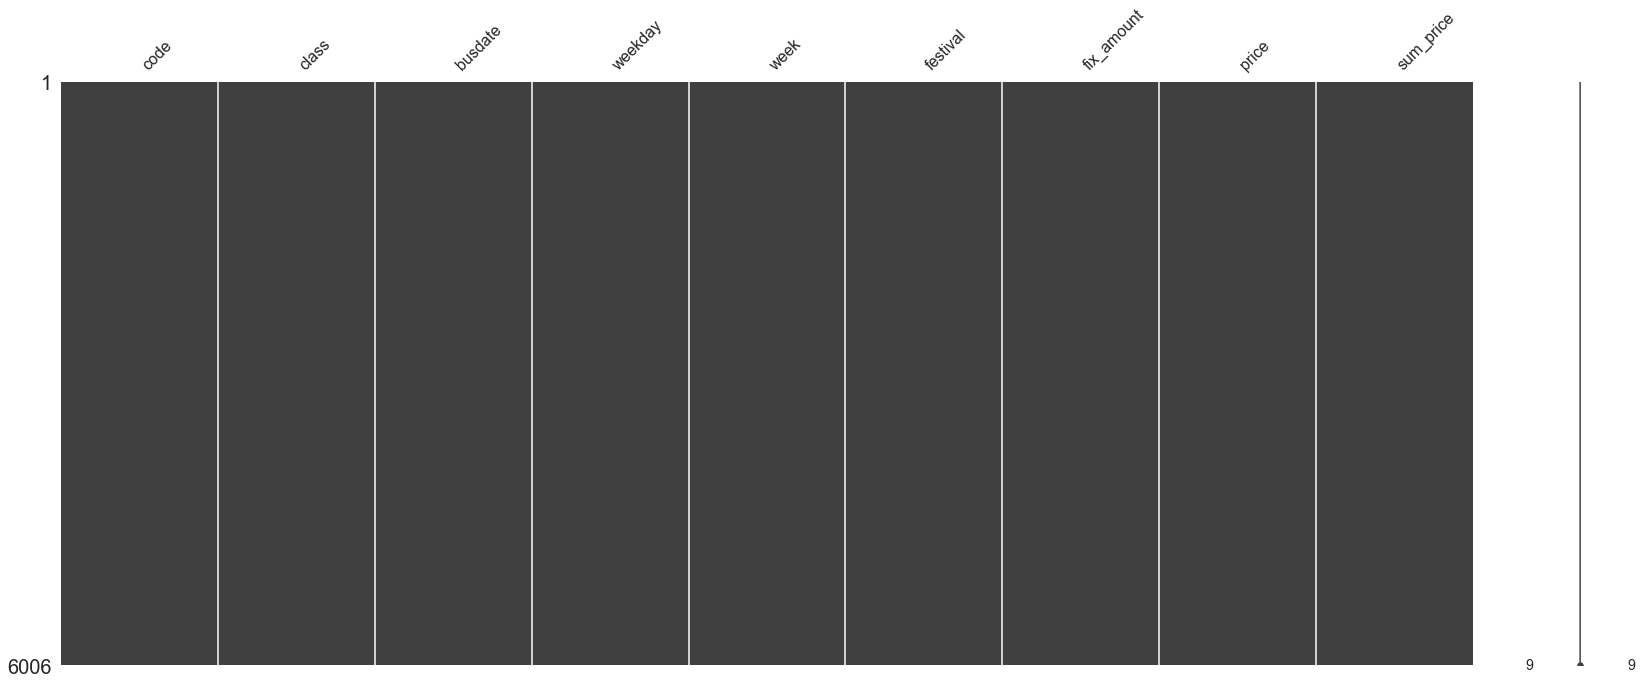

In [7]:
# 查看traimn_df中是否有null值
msno.matrix(train_df)

0    4110
2     702
5     306
7     222
6     180
1     126
3     126
4      84
9      84
8      66
Name: festival, dtype: int64

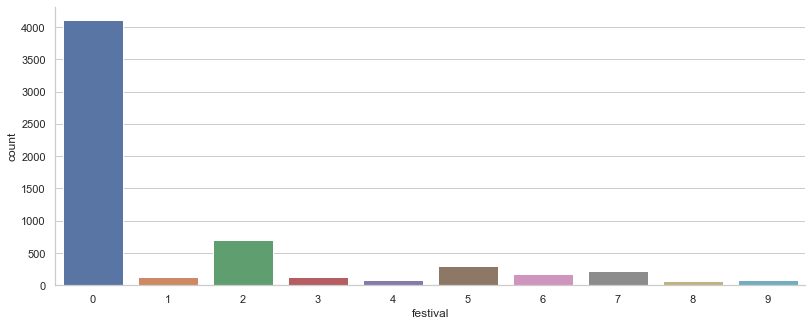

In [8]:
# 查看festival的分布律
sns.catplot(x='festival',data=train_df,kind='count',height=4.5,aspect=2.5)
train_df.festival.value_counts()

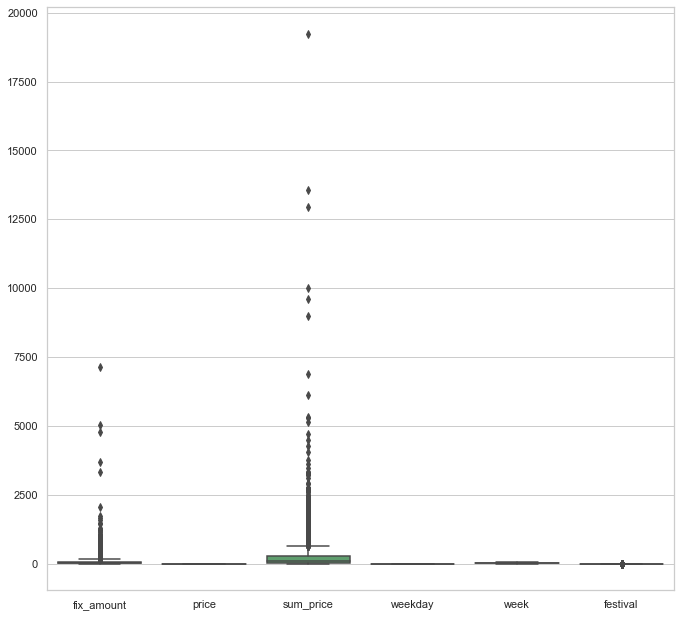

In [9]:
# 查看各变量按各单品汇总后的箱线图
sns.boxplot(data=train_df[['fix_amount', 'price', 'sum_price','weekday','week','festival']])
fig=plt.gcf()
fig.set_size_inches(10,10)

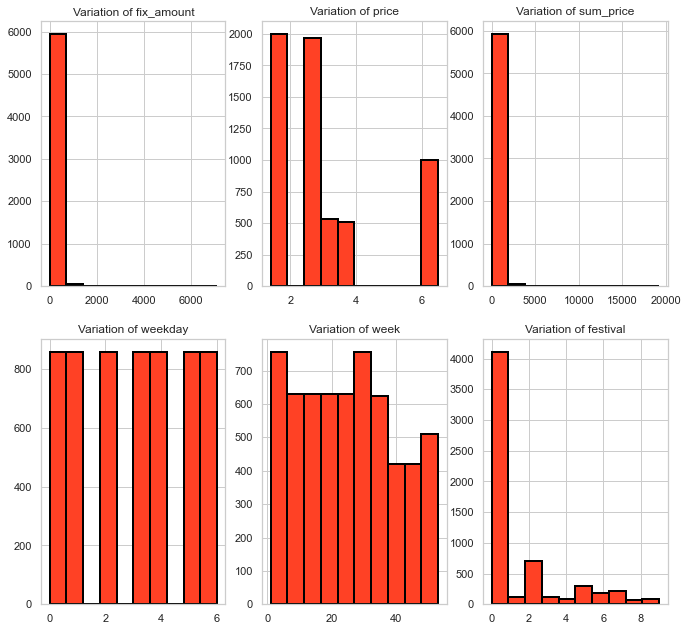

In [10]:
# 查看各变量按单品汇总后的分布律

fig,axes=plt.subplots(2,3)
axes[0,0].hist(x="fix_amount",data=train_df,edgecolor="black",linewidth=2,color='#ff4125')
axes[0,0].set_title("Variation of fix_amount")
axes[0,1].hist(x="price",data=train_df,edgecolor="black",linewidth=2,color='#ff4125')
axes[0,1].set_title("Variation of price")
axes[0,2].hist(x="sum_price",data=train_df,edgecolor="black",linewidth=2,color='#ff4125')
axes[0,2].set_title("Variation of sum_price")
axes[1,0].hist(x="weekday",data=train_df,edgecolor="black",linewidth=2,color='#ff4125')
axes[1,0].set_title("Variation of weekday")
axes[1,1].hist(x="week",data=train_df,edgecolor="black",linewidth=2,color='#ff4125')
axes[1,1].set_title("Variation of week")
axes[1,2].hist(x="festival",data=train_df,edgecolor="black",linewidth=2,color='#ff4125')
axes[1,2].set_title("Variation of festival")
fig.set_size_inches(10,10)

<AxesSubplot:>

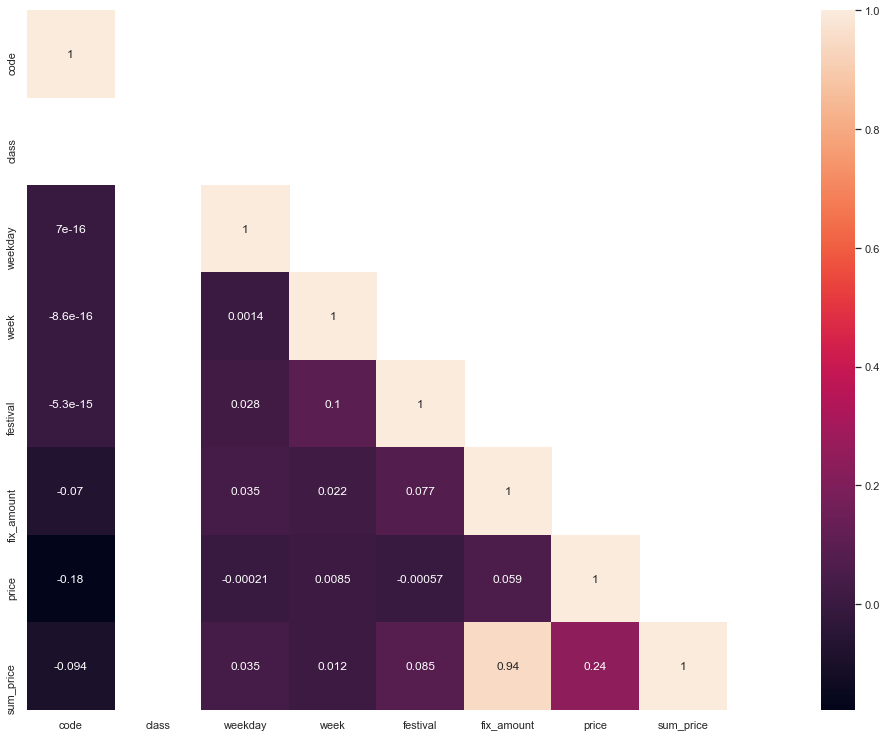

In [11]:
# 查看原始数据各变量的相关系数矩阵
cor_mat = train_df[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

In [12]:
# 开始对原始数据进行数值变换，使其与算法更适合，以提升预测精度。

In [13]:
# 减少festival变量的取值数目，使算法更容易计算其与目标变量的对应关系。
train_df['festival_fix'] = train_df.festival.replace([3,4,5,6,7,8,9],[1,1,1,1,1,1,1])
train_df.describe()
train_df

,code,class,busdate,weekday,week,festival,fix_amount,price,sum_price,festival_fix
0,6921168509256,10,2015-12-20,6,51,0,2.0,1.8,3.6,0
1,6921168509256,10,2015-12-21,0,52,0,3.0,1.8,5.4,0
2,6921168509256,10,2015-12-22,1,52,0,2.0,1.8,3.6,0
3,6921168509256,10,2015-12-23,2,52,0,2.0,1.8,3.6,0
4,6921168509256,10,2015-12-24,3,52,0,1.0,1.8,1.8,0
...,...,...,...,...,...,...,...,...,...,...
6001,6907992508191,10,2018-09-11,1,37,0,48.0,6.5,312.0,0
6002,6907992508191,10,2018-09-12,2,37,0,61.0,6.5,396.5,0
6003,6907992508191,10,2018-09-13,3,37,0,61.0,6.5,396.5,0
6004,6907992508191,10,2018-09-14,4,37,0,96.0,6.5,624.0,0


In [14]:
# 对测试集要进行相同操作，保证一致的输入数据结构。
test_df['festival_fix'] = test_df.festival.replace([3,4,5,6,7,8,9],[1,1,1,1,1,1,1])
test_df.describe()

,code,class,weekday,week,festival,fix_amount,price,sum_price,festival_fix
count,1.086000e+03,1086.0,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000
mean,6.911679e+12,10.0,2.988950,28.740331,1.740331,70.565378,3.127624,277.907195,0.635359
std,7.982875e+09,0.0,2.000891,19.639159,2.781236,98.946100,1.681505,521.461286,0.814388
min,6.901286e+12,10.0,0.000000,1.000000,0.000000,0.000000,1.500000,0.000000,0.000000
25%,6.907992e+12,10.0,1.000000,7.000000,0.000000,11.000000,1.500000,18.000000,0.000000
50%,6.907993e+12,10.0,3.000000,40.000000,0.000000,36.000000,2.800000,101.500000,0.000000
75%,6.921169e+12,10.0,5.000000,46.000000,2.000000,98.000000,3.500000,381.000000,1.000000
max,6.923644e+12,10.0,6.000000,52.000000,9.000000,1684.000000,6.500000,10946.000000,2.000000


In [15]:
# 将festival_fix变量转化为虚拟变量，使其更适用于算法。
festival = pd.get_dummies(train_df['festival_fix'],prefix='festival_fix')
train_df1 = pd.concat([train_df,festival],axis=1)
train_df2 = train_df1.drop(['festival','festival_fix'],inplace=False,axis=1)
train_df2.head()

,code,class,busdate,weekday,week,fix_amount,price,sum_price,festival_fix_0,festival_fix_1,festival_fix_2
0,6921168509256,10,2015-12-20,6,51,2.0,1.8,3.6,1,0,0
1,6921168509256,10,2015-12-21,0,52,3.0,1.8,5.4,1,0,0
2,6921168509256,10,2015-12-22,1,52,2.0,1.8,3.6,1,0,0
3,6921168509256,10,2015-12-23,2,52,2.0,1.8,3.6,1,0,0
4,6921168509256,10,2015-12-24,3,52,1.0,1.8,1.8,1,0,0


In [16]:
festival = pd.get_dummies(test_df['festival_fix'],prefix='festival_fix')
test_df1 = pd.concat([test_df,festival],axis=1)
test_df2 = test_df1.drop(['festival','festival_fix'],inplace=False,axis=1)
test_df2.describe()

,code,class,weekday,week,fix_amount,price,sum_price,festival_fix_0,festival_fix_1,festival_fix_2
count,1.086000e+03,1086.0,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000
mean,6.911679e+12,10.0,2.988950,28.740331,70.565378,3.127624,277.907195,0.580110,0.204420,0.215470
std,7.982875e+09,0.0,2.000891,19.639159,98.946100,1.681505,521.461286,0.493768,0.403463,0.411337
min,6.901286e+12,10.0,0.000000,1.000000,0.000000,1.500000,0.000000,0.000000,0.000000,0.000000
25%,6.907992e+12,10.0,1.000000,7.000000,11.000000,1.500000,18.000000,0.000000,0.000000,0.000000
50%,6.907993e+12,10.0,3.000000,40.000000,36.000000,2.800000,101.500000,1.000000,0.000000,0.000000
75%,6.921169e+12,10.0,5.000000,46.000000,98.000000,3.500000,381.000000,1.000000,0.000000,0.000000
max,6.923644e+12,10.0,6.000000,52.000000,1684.000000,6.500000,10946.000000,1.000000,1.000000,1.000000


In [17]:
# 从时间戳中提取年、月、日信息
train_df2["dayofweek"] = [t.dayofweek for t in pd.DatetimeIndex(train_df2.busdate)]
train_df2["month"] = [t.month for t in pd.DatetimeIndex(train_df2.busdate)]
train_df2['year'] = [t.year for t in pd.DatetimeIndex(train_df2.busdate)]
train_df2['year'] = train_df2['year'].map({2015:0, 2016:1, 2017:2, 2018:3})
train_df2['season'] = np.floor(train_df2['week']//14)
train_df2.describe()

,code,class,weekday,week,fix_amount,price,sum_price,festival_fix_0,festival_fix_1,festival_fix_2,dayofweek,month,year,season
count,6.006000e+03,6006.0,6006.000000,6006.000000,6006.000000,6006.000000,6006.000000,6006.000000,6006.000000,6006.000000,6006.000000,6006.000000,6006.000000,6006.000000
mean,6.911679e+12,10.0,3.000000,24.937063,76.884282,3.026427,250.895847,0.684316,0.198801,0.116883,3.000000,6.138861,1.868132,1.329670
std,7.979864e+09,0.0,2.000167,14.676836,188.232395,1.645399,575.565810,0.464827,0.399131,0.321308,2.000167,3.352958,0.808733,1.050851
min,6.901286e+12,10.0,0.000000,1.000000,0.000000,1.400000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,6.907992e+12,10.0,1.000000,12.000000,16.000000,1.500000,28.500000,0.000000,0.000000,0.000000,1.000000,3.000000,1.000000,0.000000
50%,6.907993e+12,10.0,3.000000,24.000000,38.000000,2.800000,94.500000,1.000000,0.000000,0.000000,3.000000,6.000000,2.000000,1.000000
75%,6.921169e+12,10.0,5.000000,36.000000,78.000000,3.500000,275.600000,1.000000,0.000000,0.000000,5.000000,9.000000,3.000000,2.000000
max,6.923644e+12,10.0,6.000000,53.000000,7126.000000,6.500000,19240.200000,1.000000,1.000000,1.000000,6.000000,12.000000,3.000000,3.000000


In [18]:
test_df2["dayofweek"] = [t.dayofweek for t in pd.DatetimeIndex(test_df2.busdate)]
test_df2["month"] = [t.month for t in pd.DatetimeIndex(test_df2.busdate)]
test_df2['year'] = [t.year for t in pd.DatetimeIndex(test_df2.busdate)]
test_df2['year'] = test_df2['year'].map({2018:3, 2019:4})
test_df2['season'] = np.floor(test_df2['week']//14)
test_df2.describe()

,code,class,weekday,week,fix_amount,price,sum_price,festival_fix_0,festival_fix_1,festival_fix_2,dayofweek,month,year,season
count,1.086000e+03,1086.0,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000
mean,6.911679e+12,10.0,2.988950,28.740331,70.565378,3.127624,277.907195,0.580110,0.204420,0.215470,2.988950,7.066298,3.408840,1.596685
std,7.982875e+09,0.0,2.000891,19.639159,98.946100,1.681505,521.461286,0.493768,0.403463,0.411337,2.000891,4.492208,0.491846,1.386355
min,6.901286e+12,10.0,0.000000,1.000000,0.000000,1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000
25%,6.907992e+12,10.0,1.000000,7.000000,11.000000,1.500000,18.000000,0.000000,0.000000,0.000000,1.000000,2.000000,3.000000,0.000000
50%,6.907993e+12,10.0,3.000000,40.000000,36.000000,2.800000,101.500000,1.000000,0.000000,0.000000,3.000000,10.000000,3.000000,2.000000
75%,6.921169e+12,10.0,5.000000,46.000000,98.000000,3.500000,381.000000,1.000000,0.000000,0.000000,5.000000,11.000000,4.000000,3.000000
max,6.923644e+12,10.0,6.000000,52.000000,1684.000000,6.500000,10946.000000,1.000000,1.000000,1.000000,6.000000,12.000000,4.000000,3.000000


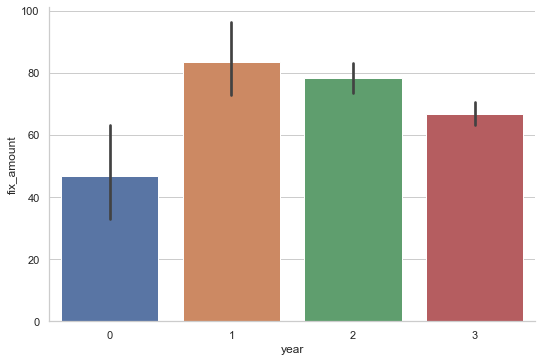

In [19]:
# 查看训练集中各单品汇总的年销量
sns.catplot(x="year",y="fix_amount",data=train_df2,kind='bar',height=5,aspect=1.5)

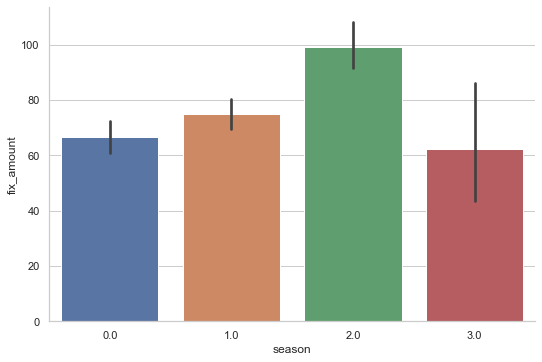

In [20]:
# 查看训练集中各单品汇总的季度销量
sns.catplot(x="season",y="fix_amount",data=train_df2,kind='bar',height=5,aspect=1.5)

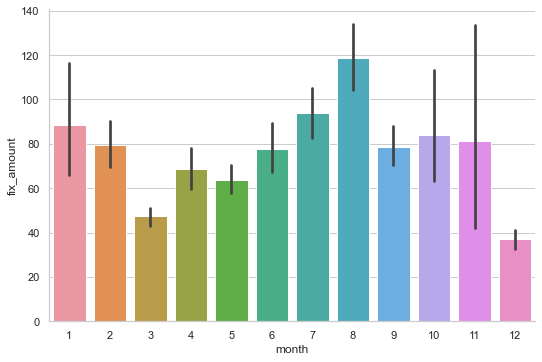

In [21]:
# 查看训练集中各单品汇总的月销量
sns.catplot(x="month",y="fix_amount",data=train_df2,kind='bar',height=5,aspect=1.5)

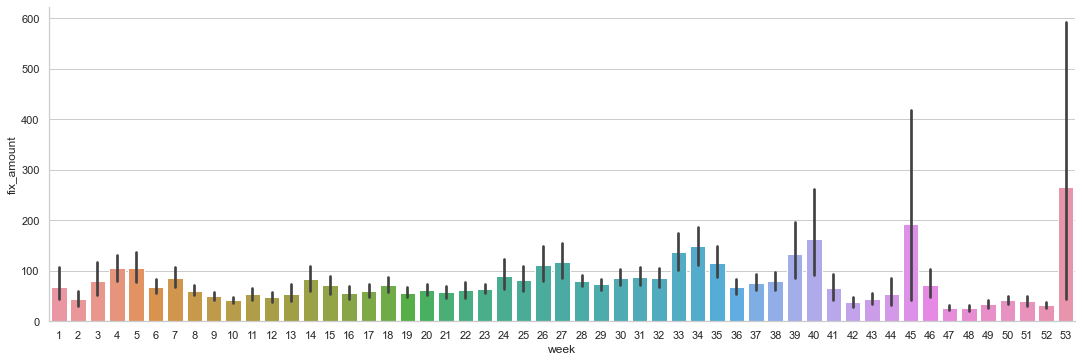

In [22]:
# 查看训练集中各单品汇总的周销量
sns.catplot(x="week",y="fix_amount",data=train_df2,kind='bar',height=5,aspect=3)

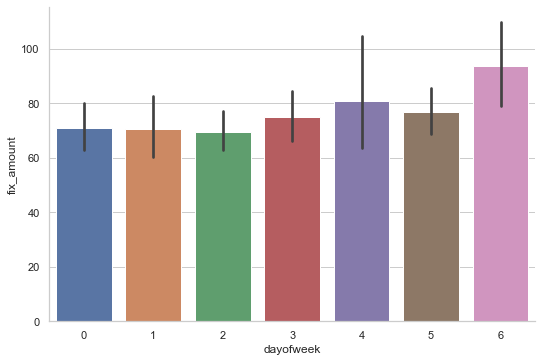

In [23]:
# 查看训练集中各单品汇总的星期销量
sns.catplot(x="dayofweek",y="fix_amount",data=train_df2,kind='bar',height=5,aspect=1.5)

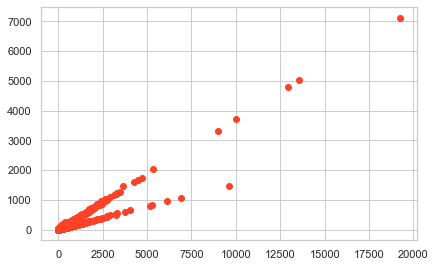

In [24]:
# 查看sum_price与fix_amount间的关系
plt.scatter(x="sum_price",y="fix_amount",data=train_df2,color='#ff4125')

<AxesSubplot:>

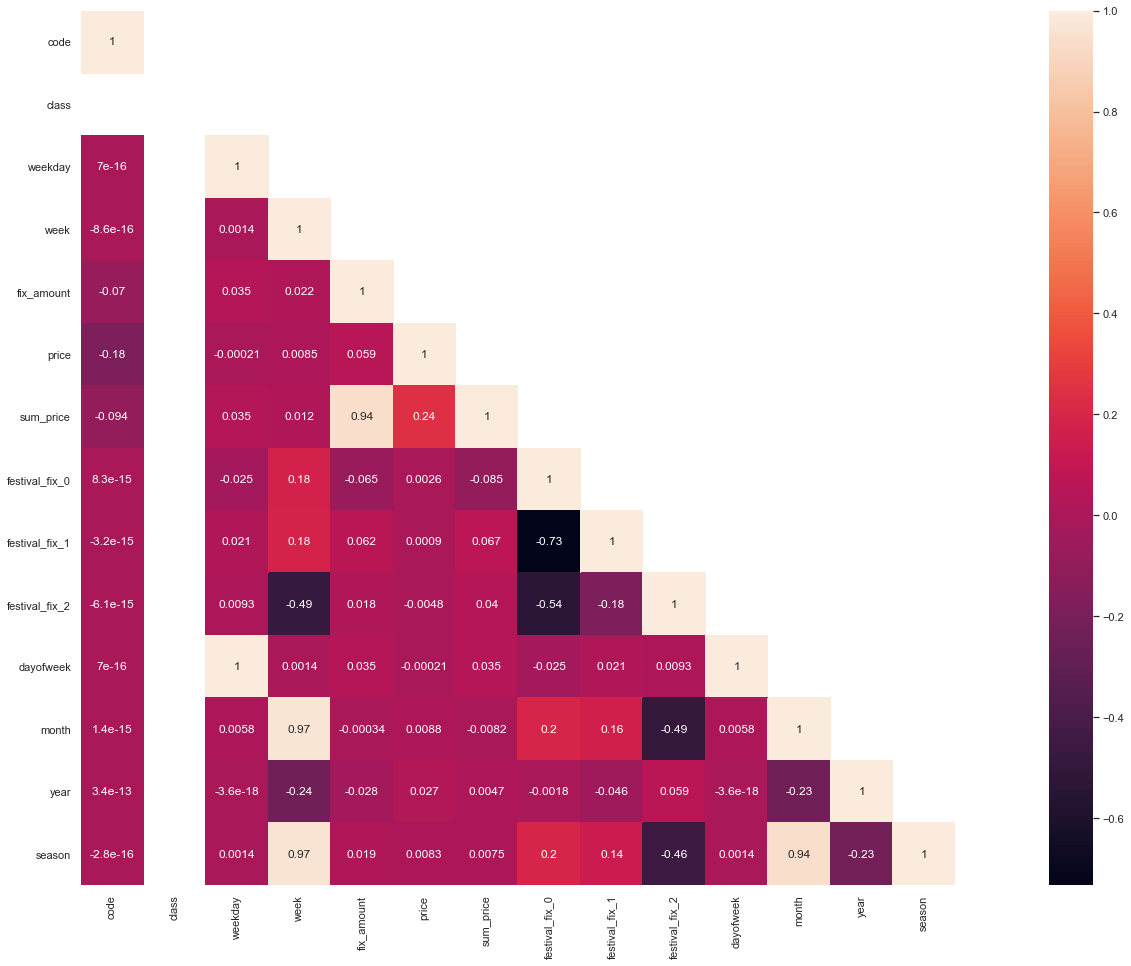

In [25]:
# 查看各变量间的相关性
cor_mat= train_df2[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,15)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

In [26]:
# 根据上一步的相关系数矩阵，确定需要输入的相关变量。
train_df3 = train_df2.drop(['busdate','code','class','weekday','fix_amount',
                            'sum_price','week','month'],axis=1,inplace=False)
test_df3 = test_df2.drop(['busdate','code','class','weekday','fix_amount',
                          'sum_price','week','month'],axis=1,inplace=False)
print(len(train_df3.columns)==len(test_df3.columns))

True


<AxesSubplot:>

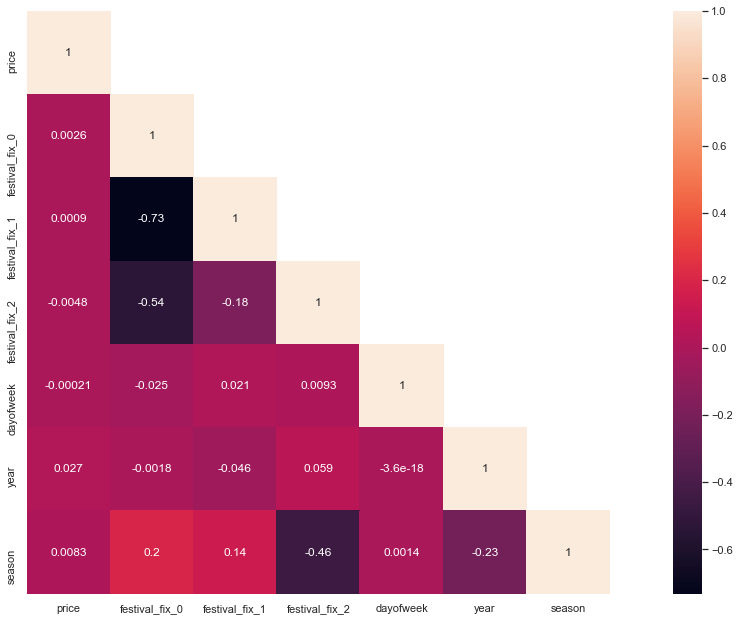

In [27]:
# 再次确认各变量相关系数
cor_mat= train_df3[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(20,10)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

In [28]:
# 查看每种数据类型的成员
train_df3.columns.to_series().groupby(train_df3.dtypes).groups

{uint8: ['festival_fix_0', 'festival_fix_1', 'festival_fix_2'], int64: ['dayofweek', 'year'], float64: ['price', 'season']}

In [29]:
train_df3.describe()
train_df3.head(10)

,price,festival_fix_0,festival_fix_1,festival_fix_2,dayofweek,year,season
0,1.8,1,0,0,6,0,3.0
1,1.8,1,0,0,0,0,3.0
2,1.8,1,0,0,1,0,3.0
3,1.8,1,0,0,2,0,3.0
4,1.8,1,0,0,3,0,3.0
5,1.8,1,0,0,4,0,3.0
6,1.8,1,0,0,5,0,3.0
7,1.8,1,0,0,6,0,3.0
8,1.8,1,0,0,0,0,3.0
9,1.8,0,1,0,1,0,3.0


In [30]:
test_df3.describe()

,price,festival_fix_0,festival_fix_1,festival_fix_2,dayofweek,year,season
count,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000
mean,3.127624,0.580110,0.204420,0.215470,2.988950,3.408840,1.596685
std,1.681505,0.493768,0.403463,0.411337,2.000891,0.491846,1.386355
min,1.500000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
25%,1.500000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000
50%,2.800000,1.000000,0.000000,0.000000,3.000000,3.000000,2.000000
75%,3.500000,1.000000,0.000000,0.000000,5.000000,4.000000,3.000000
max,6.500000,1.000000,1.000000,1.000000,6.000000,4.000000,3.000000


In [31]:
# 将相关变量和目标变量拆分成训练集和验证集
x_train,x_validate,y_train,y_validate = train_test_split(train_df3,train_df2['fix_amount'],
                                                 test_size=1/6,random_state=43,shuffle=False)
y_validate

5005     96.0
5006     98.0
5007     96.0
5008    109.0
5009    132.0
        ...  
6001     48.0
6002     61.0
6003     61.0
6004     96.0
6005     87.0
Name: fix_amount, Length: 1001, dtype: float64

In [32]:
# 使用训练集训练多种模型，用验证集比较RMSE，初步确定较优模型。

models=[RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),GradientBoostingRegressor(),
        SVR(),KNeighborsRegressor(),LinearRegression(),Ridge(),Lasso(),RidgeCV()]
model_names=['RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','GradientBoostingRegressor',
             'SVR','KNeighborsRegressor','LinearRegression','Ridge','Lasso','RidgeCV']
rmse=[]
d={}
for model in range (len(models)):
    clf=models[model]
    clf.fit(x_train,y_train)
    test_pred=clf.predict(x_validate)
    rmse.append(np.sqrt(mean_squared_error(test_pred,y_validate)))
d={'Modelling Algo':model_names,'RMSE':rmse}
rmse_frame=pd.DataFrame(d)
rmse_frame

,Modelling Algo,RMSE
0,RandomForestRegressor,104.802441
1,AdaBoostRegressor,103.473989
2,BaggingRegressor,104.040148
3,GradientBoostingRegressor,108.060110
4,SVR,109.515903
5,KNeighborsRegressor,105.035829
6,LinearRegression,185.212598
7,Ridge,185.923416
8,Lasso,179.318175
9,RidgeCV,185.473122


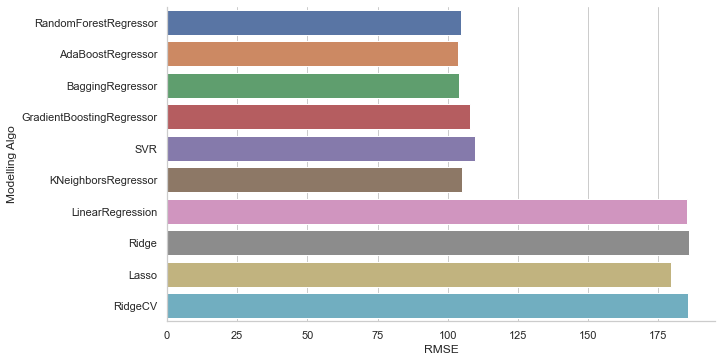

In [33]:
# 查看各算法的RMSE
sns.catplot(y='Modelling Algo',x='RMSE',data=rmse_frame,kind='bar',height=5,aspect=2)

In [34]:
# 对SVR进行超参数优化，并得出最终预测结果。

In [35]:
# 再次使用训练集训练SVR，并用验证集观察RMSE，确定超参数。

params_dict = {"C":list(range(1,31,10))}
clf_svr = GridSearchCV(estimator=SVR(), param_grid=params_dict, scoring='neg_mean_squared_error')
clf_svr.fit(x_train,y_train)
pred = clf_svr.predict(x_validate)
print((np.sqrt(mean_squared_error(pred,y_validate))))
clf_svr.best_params_

158.36088619295762


{'C': 11}

In [36]:
# 最后用训练集加验证集再次训练SVR，此时模型的超参数设为上一步所得的最优超参数，并由此得出最终预测结果。

params_dict = {'C':[clf_svr.best_params_['C']]}
clf_svr = GridSearchCV(estimator=SVR(), param_grid=params_dict, scoring='neg_mean_squared_error')
clf_svr.fit(train_df3, train_df2['fix_amount'])
pred = clf_svr.predict(test_df3)
d = {'datetime':test_df2['busdate'],'pred_svr':pred}
pred_svr = pd.DataFrame(d)
print(pred_svr.head())
print(pred_svr.tail())

     datetime   pred_svr
0  2018-09-16  29.550374
1  2018-09-17  28.286967
2  2018-09-18  26.879362
3  2018-09-19  24.645264
4  2018-09-20  23.121546
        datetime   pred_svr
1081  2019-03-11  48.405531
1082  2019-03-12  52.175390
1083  2019-03-13  54.451877
1084  2019-03-14  56.660919
1085  2019-03-15  59.625259


In [37]:
# 对RandomForestRegressor进行超参数优化，并得出最终预测结果。

In [38]:
# 再次使用训练集训练RandomForestRegressor，并用验证集观察RMSE，确定超参数。

params_dict = {'n_estimators':list(range(550,701,50)), 'n_jobs':[-1]}
clf_rf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=params_dict, scoring='neg_mean_squared_error')
clf_rf.fit(x_train, y_train)
pred = clf_rf.predict(x_validate)
print((np.sqrt(mean_squared_error(pred,y_validate))))
clf_rf.best_params_

104.56164759330332


{'n_estimators': 600, 'n_jobs': -1}

In [39]:
# 最后用训练集加验证集再次训练RandomForestRegressor，此时模型的超参数设为上一步所得的最优超参数，并由此得出最终预测结果。

params_dict = {'n_estimators':[clf_rf.best_params_['n_estimators']], 'n_jobs':[clf_rf.best_params_['n_jobs']]}
clf_rf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=params_dict, scoring='neg_mean_squared_error')
clf_rf.fit(train_df3, train_df2['fix_amount'])
pred=clf_rf.predict(test_df3)
d={'datetime':test_df2['busdate'], 'pred_rf':pred}
pred_rf=pd.DataFrame(d)
print(pred_rf.head())
print(pred_rf.tail())

     datetime    pred_rf
0  2018-09-16  29.450610
1  2018-09-17  42.878934
2  2018-09-18  35.281661
3  2018-09-19  34.679880
4  2018-09-20  32.038063
        datetime    pred_rf
1081  2019-03-11  58.126904
1082  2019-03-12  66.010188
1083  2019-03-13  55.046321
1084  2019-03-14  36.739914
1085  2019-03-15  51.777573


In [40]:
# 对Lasso进行超参数优化，并得出最终预测结果。

In [41]:
# 再次使用训练集训练Lasso，并用验证集观察RMSE，确定超参数。

params_dict = {'alpha':list(range(-10,10,1)), 'max_iter':list(range(int(1e3),int(1e4+1),int(1e3)))}
clf_la = GridSearchCV(estimator=Lasso(), param_grid=params_dict, scoring='neg_mean_squared_error')
clf_la.fit(x_train, y_train)
pred = clf_la.predict(x_validate)
print((np.sqrt(mean_squared_error(pred,y_validate))))
clf_la.best_params_

131.43585324062636


{'alpha': 9, 'max_iter': 1000}

In [42]:
# 最后用训练集加验证集再次训练Lasso，此时模型的超参数设为上一步所得的最优超参数，并由此得出最终预测结果。

params_dict = {'alpha':[clf_la.best_params_['alpha']], 'max_iter':[clf_la.best_params_['max_iter']]}
clf_la = GridSearchCV(estimator=Lasso(), param_grid=params_dict, scoring='neg_mean_squared_error')
clf_la.fit(train_df3, train_df2['fix_amount'])
pred = clf_la.predict(test_df3)
d={'datetime':test_df2['busdate'], 'pred_la':pred}
pred_la=pd.DataFrame(d)
print(pred_la.head())
print(pred_la.tail())

     datetime    pred_la
0  2018-09-16  74.764047
1  2018-09-17  68.626147
2  2018-09-18  69.649131
3  2018-09-19  70.672114
4  2018-09-20  71.695097
        datetime    pred_la
1081  2019-03-11  85.623959
1082  2019-03-12  86.646942
1083  2019-03-13  87.669925
1084  2019-03-14  88.692909
1085  2019-03-15  89.715892


In [43]:
# 以KNeighborsRegressor为例优化超参数，并得出最终预测结果。

In [44]:
# 再次使用训练集训练KNeighborsRegressor，并用验证集观察RMSE，确定最优超参数。

n_neighbors=[]
for i in range (0,91,15):
    if(i!=0):
        n_neighbors.append(i)
params_dict = {'n_neighbors':n_neighbors,'n_jobs':[-1]}
clf_knn = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=params_dict, scoring='neg_mean_squared_error')
clf_knn.fit(x_train,y_train)
pred = clf_knn.predict(x_validate)
print((np.sqrt(mean_squared_error(pred,y_validate))))
clf_knn.best_params_

104.17626496231046


{'n_jobs': -1, 'n_neighbors': 90}

In [45]:
# 最后用训练集加验证集再次训练KNeighborsRegressor，此时模型的超参数设为上一步所得的最优超参数，并由此得出最终预测结果。

params_dict = {'n_neighbors':[clf_knn.best_params_['n_neighbors']], 'n_jobs':[clf_knn.best_params_['n_jobs']]}
clf_knn = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=params_dict, scoring='neg_mean_squared_error')
clf_knn.fit(train_df3, train_df2['fix_amount'])
pred = clf_knn.predict(test_df3)
d={'datetime':test_df2['busdate'], 'pred_knn':pred}
pred_knn = pd.DataFrame(d)
print(pred_knn.head())
print(pred_knn.tail())

     datetime   pred_knn
0  2018-09-16  50.177778
1  2018-09-17  59.122222
2  2018-09-18  32.677778
3  2018-09-19  30.988889
4  2018-09-20  29.755556
        datetime    pred_knn
1081  2019-03-11   84.455556
1082  2019-03-12   85.422222
1083  2019-03-13   82.955556
1084  2019-03-14  100.277778
1085  2019-03-15   78.377778


In [46]:
# 最后将以上4个预测结果与实际销量汇总

In [47]:
predict = pd.concat([pred_svr, pred_rf.pred_rf, pred_la.pred_la, pred_knn.pred_knn, test_df.fix_amount],axis=1)
predict.to_csv('predict_ML.csv', index=False)
predict

,datetime,pred_svr,pred_rf,pred_la,pred_knn,fix_amount
0,2018-09-16,29.550374,29.450610,74.764047,50.177778,12.0
1,2018-09-17,28.286967,42.878934,68.626147,59.122222,7.0
2,2018-09-18,26.879362,35.281661,69.649131,32.677778,5.0
3,2018-09-19,24.645264,34.679880,70.672114,30.988889,15.0
4,2018-09-20,23.121546,32.038063,71.695097,29.755556,12.0
...,...,...,...,...,...,...
1081,2019-03-11,48.405531,58.126904,85.623959,84.455556,48.0
1082,2019-03-12,52.175390,66.010188,86.646942,85.422222,61.0
1083,2019-03-13,54.451877,55.046321,87.669925,82.955556,96.0
1084,2019-03-14,56.660919,36.739914,88.692909,100.277778,61.0


In [48]:
# 需要准备的预测相关变量：
# 一. 时序类：
# 1.农历日期或农历假日标签，2.当地的天气、平均温度、平均相对湿度，3.促销分类标签，4.陈列位置分类标签，5.除促销外的其他异常事件标签，
# 6.商店人流量，7.单品价格，8.单品销售额，9.采购订单历史记录（采购量、采购额），10.缺货历史记录（数量），
# 11.竞争对手价格、销售额、销量，12.与该单品相似商品的各种历史数据，13.门店营业天数及单品在销天数，14.地区相关门店的其他信息，
# 15.星期（对日序列）、月份、季度，16.距保质期末剩余天数，17.降雨量，18.日照时长、光照量，19.风力及风向，
# 二. 非时序类：
# 1.地区总人口、GDP、GNP、CPI、地区失业率、人均可支配收入等在统计局网站所能获取的经济指标，2.门店位置标签或门店编号、门店类型，3.地区房屋均价、租金，
# 4.单品所属部门类型或编号，5.地区相关门店的其他信息，6.商品相关属性，如生产商、品牌、材料、颜色、形状、尺寸，7.地区能源价格如电价、油价等，